In [1]:
# pip install opencv-python

In [1]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pathlib
import os
import cv2
import datetime

from os import listdir
from os.path import isfile, isdir, join
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.9.1
numpy:       1.23.2
matplotlib:  3.5.3
sklearn:     1.1.2


In [2]:
modelname   = 'tiny'

IMG_SIZE = 180 # Specify height and width of image to match the input format of the model
IMG_WIDTH = IMG_SIZE
IMG_HEIGHT = IMG_SIZE
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
BATCH_SIZE = 32 # Big enough to measure an F1-score
AUTOTUNE = tf.data.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations
SEED = 7
N_LABELS = 0
EPOCHS = 20
OPT_IDX = 1
ACTIVATION = 'softmax'

class_names = ''
modelname = modelname+"_"+str(IMG_SIZE)+"_"+str(EPOCHS)+"_"+str(BATCH_SIZE)+"_"+str(OPT_IDX)
optmzs = ['adam', optimizers.RMSprop(learning_rate=0.0001)]
optmz = optmzs[OPT_IDX]

In [3]:
def readImagesFromDir(base_img_path='dataset/'):
    dirs = [d for d in listdir(base_img_path) if isdir(join(base_img_path, d)) and not d.startswith('.')]

    print(dirs)

    X, y = [], []

    for d in dirs:
        img_path = base_img_path + d + "/"
        files = [f for f in listdir(img_path) if isfile(join(img_path, f))]
        X = X + [os.path.join(img_path, f) for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        y = y + [d for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        #print(d)

    data_dir = Path(base_img_path)
    image_count = len(list(data_dir.glob('*/*.*')))
    
    return X, y


def preprocess_image(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_HEIGHT, IMG_WIDTH], preserve_aspect_ratio=False)
    # Normalise the image
    image_normalized = image_resized / 255.0
    
    return image_normalized, label


def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        #dataset = dataset.take(BATCH_SIZE)
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        #dataset = dataset.repeat()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps    
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset


def predict_new_image(img_file):    
    img = tf.keras.utils.load_img(
        img_file, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    #img_array = np.array([img_array])

    saved_model = load_model(model_file)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    #score = tf.sigmoid(predictions[0])
    #score = tf.nn.sigmoid_cross_entropy_with_logits(labels=class_names, logits=predictions[0])
    #score = tf.math.sigmoid(predictions[0])
    #score = tf.tanh(predictions[0])

    #model.evaluate(img_array)
    plt.imshow(img)
    plt.show()

    #print(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print()

In [4]:
X, Y = readImagesFromDir()

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=SEED)

lb = LabelBinarizer()
lb.fit(y_train)
class_names = lb.classes_
# Loop over all labels and show them    
N_LABELS = len(class_names)
for (i, label) in enumerate(class_names):
    print("{}. {}".format(i, label))

# transform the targets of the training and test sets
y_train_bin = lb.transform(y_train)
y_val_bin = lb.transform(y_val)

print(y_train_bin.shape)
print(y_val_bin.shape)

['oranda', 'luohan', 'arrowana', 'betta_fish', 'common_goldfish']
0. arrowana
1. betta_fish
2. common_goldfish
3. luohan
4. oranda
(3612, 5)
(903, 5)


In [5]:
# Print examples of fish and their binary targets
for i in range(10):
    print(X_train[len(X_train)-1 - i], y_train_bin[len(y_train_bin)-1 - i])

dataset/common_goldfish/frame10060.jpg [0 0 1 0 0]
dataset/luohan/240_F_283318420_AZ9wuMdk7VQUrG6sI01yI6MXT2AjzIY0.jpg [0 0 0 1 0]
dataset/oranda/frame25970.jpg [0 0 0 0 1]
dataset/arrowana/Arrowana10558.jpg [1 0 0 0 0]
dataset/common_goldfish/frame1340.jpg [0 0 1 0 0]
dataset/luohan/005739e50235a438.jpg [0 0 0 1 0]
dataset/luohan/istockphoto-647967728-612x612.jpg [0 0 0 1 0]
dataset/betta_fish/betta0187.jpg [0 1 0 0 0]
dataset/arrowana/Arrowana10683.jpg [1 0 0 0 0]
dataset/common_goldfish/frame20120.jpg [0 0 1 0 0]


In [6]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin, is_training=False)

for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)
    
for f, l in val_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

2022-09-21 23:41:28.347016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-21 23:41:28.374604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-21 23:41:28.374832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-21 23:41:28.375479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Shape of features array: (32, 180, 180, 3)
Shape of labels array: (32, 5)
Shape of features array: (32, 180, 180, 3)
Shape of labels array: (32, 5)


2022-09-21 23:41:30.053143: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:
def createModel():
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(N_LABELS, activation=ACTIVATION))
    model.compile(loss='categorical_crossentropy', optimizer=optmz, metrics=['accuracy'])
    return model

model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 259200)            0         
                                                                 
 dense (Dense)               (None, 32)                8294432   
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 8,295,493
Trainable params: 8,295,493
Non-trainable params: 0
______________________________________________

In [8]:
                                                                                # Step 1
modelname       = modelname+"_"+str(datetime.datetime.now())[:-7].replace(' ','_').replace(":",'-')
folderpath      = 'models/'
model_file      = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(model_file, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Path to model:", model_file)
print("Path to log:  ", folderpath+modelname+'.csv')

Path to model: models/tiny_180_20_32_1_2022-09-21_23-41-38.hdf5
Path to log:   models/tiny_180_20_32_1_2022-09-21_23-41-38.csv


In [9]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')
print("Path to plot:", plotpath)

Path to plot: models/tiny_180_20_32_1_2022-09-21_23-41-38_plot.png


In [10]:
import time as time

start = time.time()
history = model.fit(train_ds,                            # Training data and label
          validation_data=val_ds,   # Validation data and label
          epochs=EPOCHS,                       # The amount of epochs to be trained
          batch_size=BATCH_SIZE,                   
          shuffle=True,                     # To shuffle the training data
          verbose=0,
          callbacks=callbacks_list)         # Callbacks to execute the checkpoints

end = time.time()
duration = round(((end - start)/60), 2)
print("duration = ", duration, " minutes")

2022-09-21 23:41:45.203132: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303
2022-09-21 23:41:46.318694: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-21 23:41:46.443410: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-09-21 23:41:47.747736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


duration =  0.48  minutes


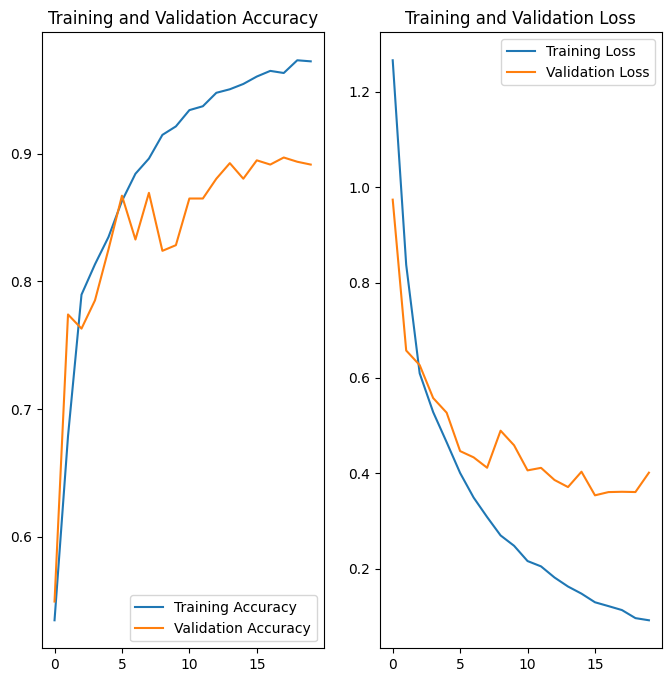

In [11]:
# Plot the accuracy and error on training and test sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(folderpath+modelname+'_accuracy_plot.png')
plt.show()

In [12]:
                                                                                # Step 1
modelGo.load_weights(model_file)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

predicts    = modelGo.predict(val_ds)                                            # Step 2
print("Prediction completes.")

29/29 [==============================] - 0s 7ms/step
Prediction completes.


In [13]:
                                                                                # Step 1
                                                                                # Step 2
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(y_val_bin,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

report = metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4,
                                      output_dict=True)

df = pd.DataFrame(report).transpose()
df.to_csv(folderpath+modelname+'_report.csv')

Best accuracy (on testing dataset): 89.70%
                 precision    recall  f1-score   support

       arrowana     0.8844    0.9263    0.9049       190
     betta_fish     0.8807    0.9014    0.8910       213
common_goldfish     1.0000    0.9591    0.9791       171
         luohan     0.8732    0.8364    0.8544       214
         oranda     0.8462    0.8609    0.8534       115

       accuracy                         0.8970       903
      macro avg     0.8969    0.8968    0.8966       903
   weighted avg     0.8979    0.8970    0.8971       903



1/1 [==============================] - 0s 15ms/step


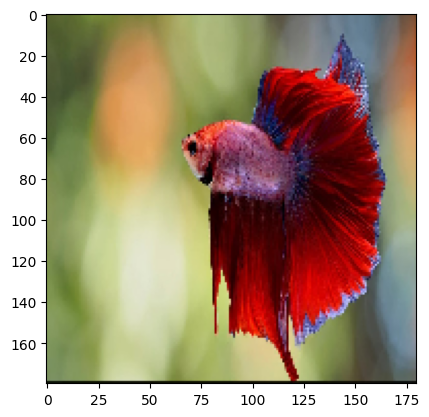

This image most likely belongs to betta_fish with a 40.46 percent confidence.

1/1 [==============================] - 0s 15ms/step


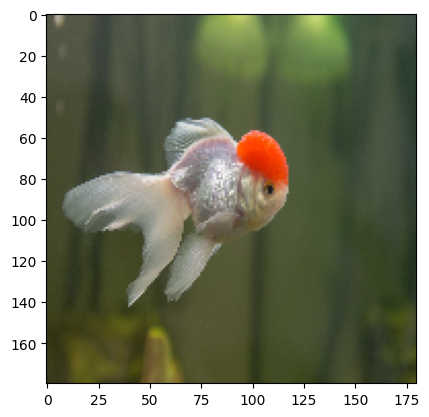

This image most likely belongs to oranda with a 40.46 percent confidence.

1/1 [==============================] - 0s 17ms/step


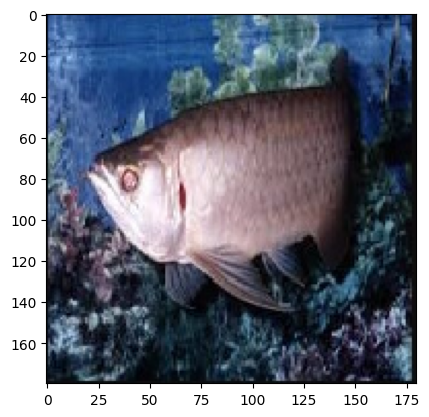

This image most likely belongs to luohan with a 40.46 percent confidence.

1/1 [==============================] - 0s 25ms/step


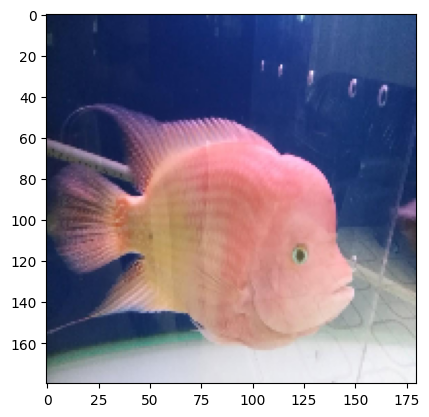

This image most likely belongs to luohan with a 40.46 percent confidence.

1/1 [==============================] - 0s 19ms/step


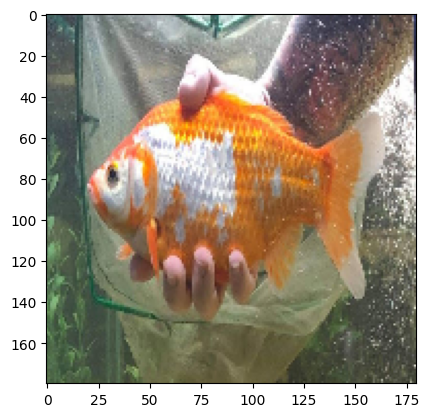

This image most likely belongs to luohan with a 40.46 percent confidence.



In [17]:
# make predictions

predict_new_image("validate/Screenshot 2022-09-08 210113.jpg")
predict_new_image("validate/0221faa8b79c4b2eb4dfee6f46912d74.jpg")
predict_new_image("validate/Screenshot 2022-09-22 015830.jpg")
predict_new_image("validate/jin_gan_luohan_fish_1558328530_b38f1646_progressive.jpg")
predict_new_image("validate/word-image.jpeg")
